## Respondendo novas perguntas do CEO

Dataset disponível em: https://www.kaggle.com/harlfoxem/housesalesprediction

1. Qual a média do preço de compra dos imóveis por "Nível"?
    - Nível 0 -> Preço entre 0 e 321.950
    - Nível 1 -> Preço entre 321.950 e 450.000
    - Nível 2 -> Preço entre 450.000 e 645.000
    - Nível 3 -> Acima de 645.000

In [1]:
# Importando bibliotecas
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Carregando dataset
df = pd.read_csv('datasets/kc_house_data.csv')

df['level'] = df['price'].apply(lambda x: 0 if x <= 321950 else
                            1 if (x > 321950) & (x <= 450000) else
                            2 if (x > 450000) & (x <= 645000) else
                            3)
df['level'] = df['level'].astype(int)

df[['price', 'level']].groupby('level').mean().reset_index()

,level,price
0,0,251557.65
1,1,385688.68
2,2,539730.96
3,3,987540.22


2. Qual a média do tamanho da sala de estar dos imóveis por "Size"?
    - Size 0 -> Tamanho entre 0 e 1427 sqft
    - Size 1 -> Tamanho entre 1427 e 1910 sqft
    - Size 2 -> Tamanho entre 1910 e 2550 sqft
    - Size 3 -> Acima de 2550 sqft

In [2]:
df['size'] = df['sqft_living'].apply(lambda x: 0 if x <= 1427 else
                                1 if(x > 1427) & (x <= 1910) else
                                2 if(x > 1910) & (x <= 2550) else
                                3)
df['size'] = df['size'].astype(int)

df[['sqft_living', 'size']].groupby('size').mean().reset_index()

,size,sqft_living
0,0,1123.83
1,1,1664.96
2,2,2211.79
3,3,3329.61


3. Adicione as seguintes informações ao conjunto de dados original:
    - Place ID: Identificação da localização
    - OSM Type: Open Street Map Type
    - Country: Nome do País
    - Country Code: Código do País

In [3]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent='geoapiExercises')

query='47.51,-122.26'
response = geolocator.reverse(query)
response.raw

{'place_id': 158810523,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 236673776,
 'lat': '47.50987735',
 'lon': '-122.26001908123574',
 'display_name': '5746, South Ryan Street, Rainier Beach, Seattle, King County, Washington, 98178, United States',
 'address': {'house_number': '5746',
  'road': 'South Ryan Street',
  'neighbourhood': 'Rainier Beach',
  'city': 'Seattle',
  'county': 'King County',
  'state': 'Washington',
  'ISO3166-2-lvl4': 'US-WA',
  'postcode': '98178',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['47.509808', '47.5099694', '-122.2600792', '-122.259959']}

In [6]:
import time
import defs
from multiprocessing import Pool

df['query'] = df[['lat', 'long']].apply(
    lambda x: str(x['lat']) + ',' + str(x['long']), axis=1
)


df1 = df[['id', 'query']].head()

p = Pool(2)

start = time.process_time()
df1[['place_id', 'osm_type', 'country', 'country_code']] = p.map(defs.get_data, df1.iterrows())
end = time.process_time()

print('Time Elapsed: {}', end - start)

Time Elapsed: {} 0.023404337999999747


In [7]:
df1.head()

,id,query,place_id,osm_type,country,country_code
0,7129300520,"47.5112,-122.257",161022547,way,United States,us
1,6414100192,"47.721,-122.319",160016678,way,United States,us
2,5631500400,"47.7379,-122.233",74951055,node,United States,us
3,2487200875,"47.5208,-122.393",156726151,way,United States,us
4,1954400510,"47.6168,-122.045",296045104,way,United States,us


4. Adicione os seguintes filtros no Mapa:
    - Tamanho mínimo da área da sala de estar
    - Número mínimo de banheiros
    - Valor máximo do preço
    - Tamanho máximo da área do porão
    - Filtro das condições do imóvel
    - Filtro por ano de construção

In [8]:
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import fixed

style={'description_width': 'initial'}

df['is_waterfront'] = df['waterfront'].apply(
    lambda x: 'yes' if x == 1
        else  'no')

# Interative buttons
min_living_room = widgets.IntSlider(
    value=int(df['sqft_living'].mean()),
    min=df['sqft_living'].min(),
    max=df['sqft_living'].max(),
    step=1,
    description='Minimum Living Room Size',
    disabled=False,
    style=style
)


min_bathrooms = widgets.IntSlider(
    value=int(df['bathrooms'].mean()),
    min=df['bathrooms'].min(),
    max=10,
    step=1,
    description='Minimum Bathrooms Values',
    disabled=False,
    style=style
)


max_price = widgets.FloatSlider(
    value=int(df['price'].mean()),
    min=int(df['price'].min()),
    max=int(df['price'].max()),
    step=1,
    description='Maximum Price',
    disabled=False,
    style=style
)


max_basement = widgets.FloatSlider(
    value=int(df['sqft_basement'].mean()),
    min=df['sqft_basement'].min(),
    max=df['sqft_basement'].max(),
    step=1,
    description='Maximum Basement Size',
    disabled=False,
    style=style
)

condition_house = widgets.Dropdown(
    options=df['condition'].sort_values().unique().tolist(),
    value=int(df['condition'].mean()),
    description='Condition House',
    disable=False,
    style=style
)

year_built = widgets.Dropdown(
    options=df['yr_built'].sort_values().unique().tolist(),
    value=int(df['yr_built'].mean()),
    description='Year Built',
    disable=False,
    style=style
)

def update_map(data, living_room, min_bathrooms, max_price, basement, condition_house, year_built):
    
    houses = data[(data['sqft_living'] > living_room) &                              (data['bathrooms'] > min_bathrooms) &                              (data['price'] < max_price) & 
                  (data['sqft_basement'] < basement) &                                (data['condition'] == condition_house) &                            (data['yr_built'] > year_built)][['id', 'lat', 'long', 'price', 'sqft_living', 'level']].copy()
    
    # plot map
    fig = px.scatter_mapbox(houses,
                    lat='lat',
                    lon='long',
                    color='level',
                    size='price',                                                        color_continuous_scale=px.colors.cyclical.IceFire,
                    size_max=15,
                    zoom=10)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()
    
# Plot map    
widgets.interactive(update_map, 
                    data = fixed(df), 
                    living_room = min_living_room, 
                    min_bathrooms = min_bathrooms, 
                    max_price = max_price, 
                    basement = max_basement, 
                    condition_house = condition_house, 
                    year_built = year_built)

interactive(children=(IntSlider(value=2079, description='Minimum Living Room Size', max=13540, min=290, style=…

5. Adicione os seguintes filtros no Dashboard:
    - Filtro por data disponível para compra
    - Filtro por ano de renovação
    - Filtro se possui vista para a água ou não

interactive(children=(SelectionSlider(continuous_update=False, description='Max Available Date', index=212, op…

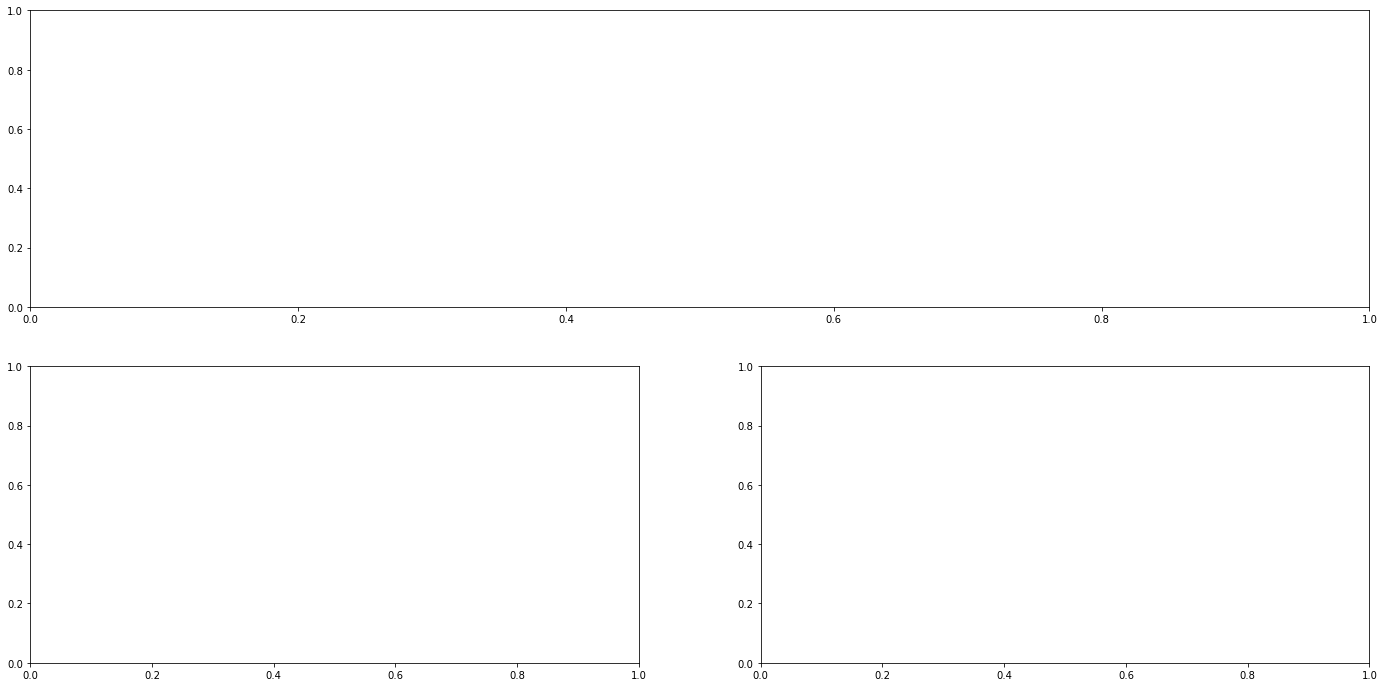

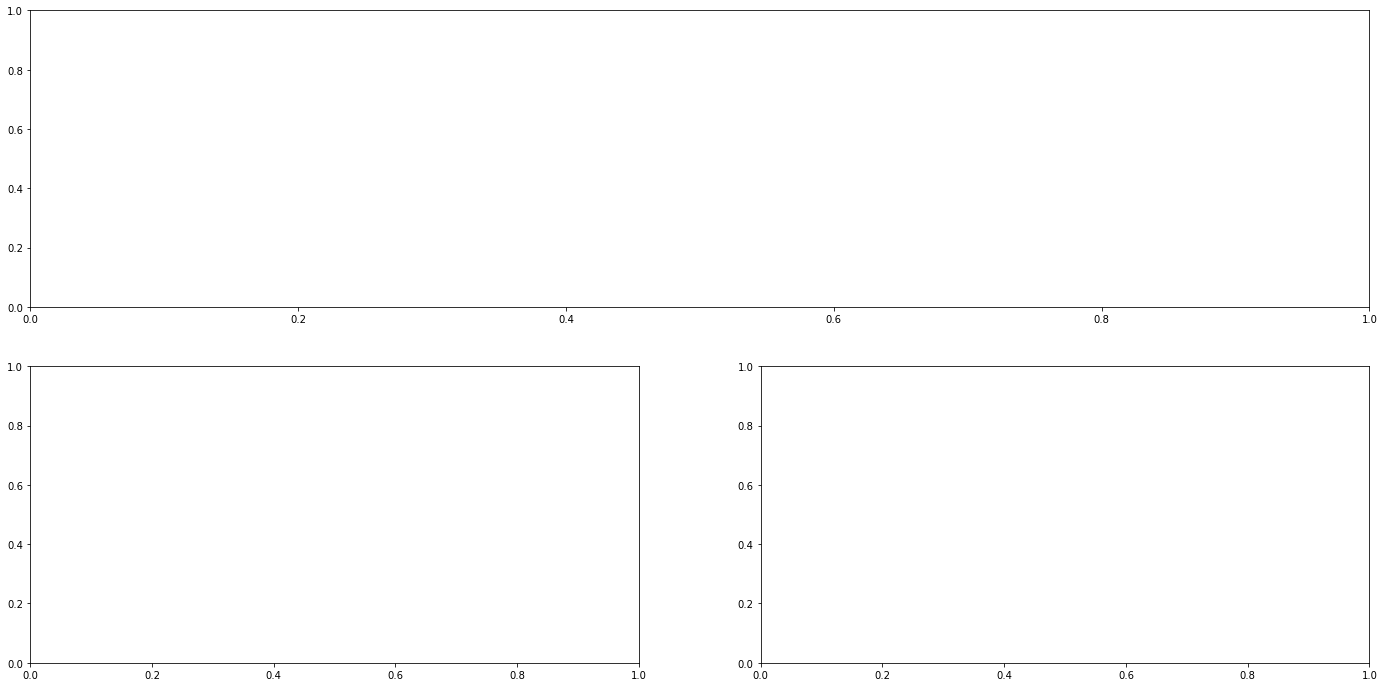

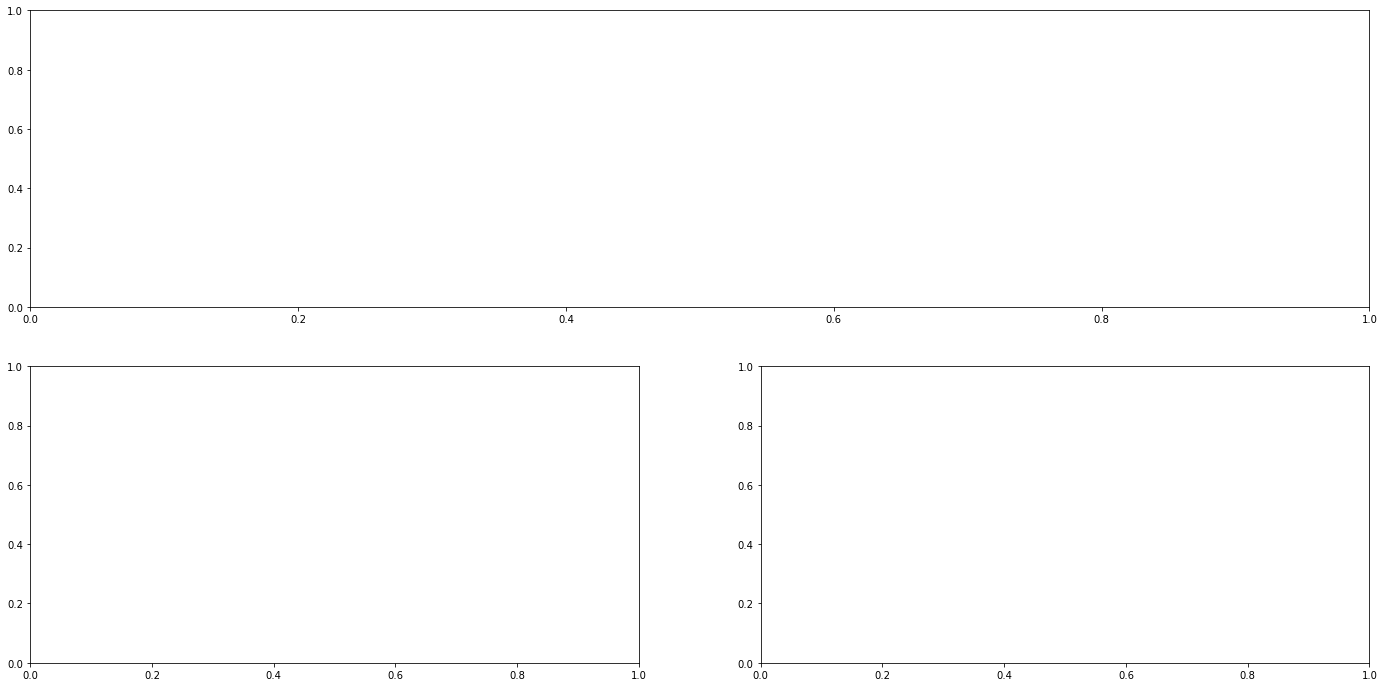

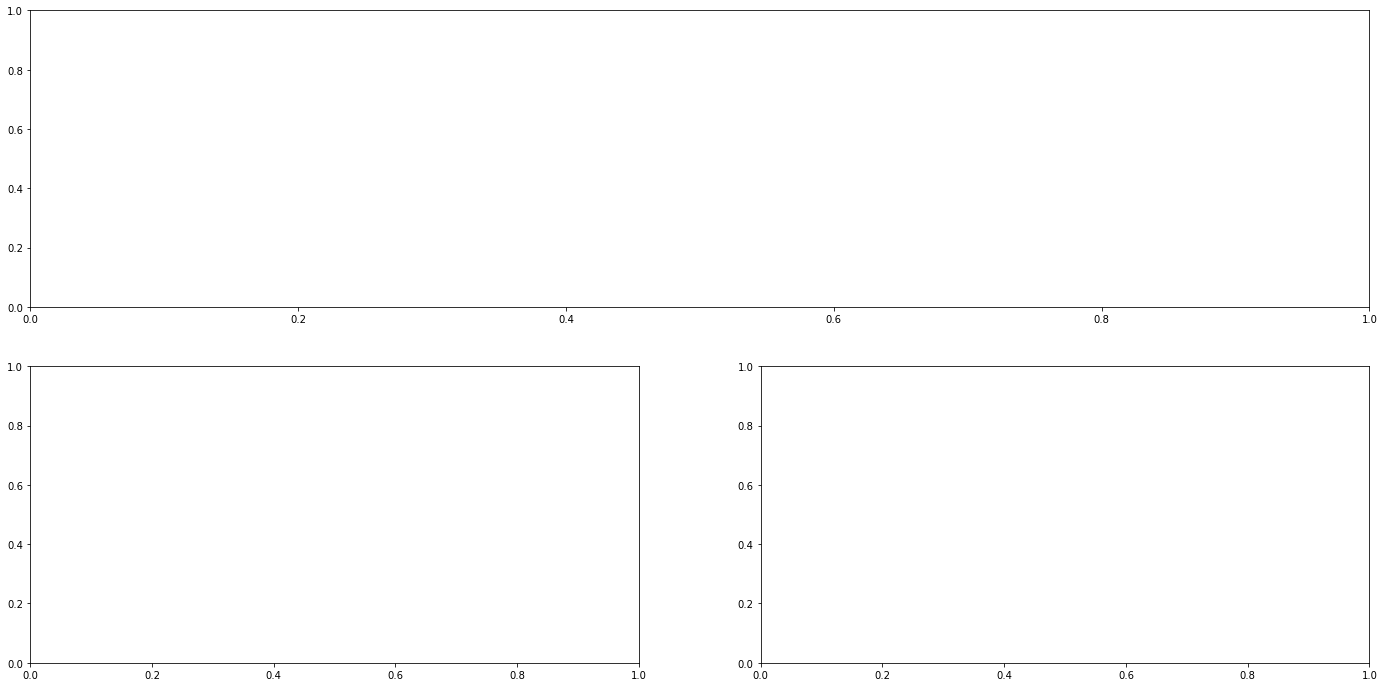

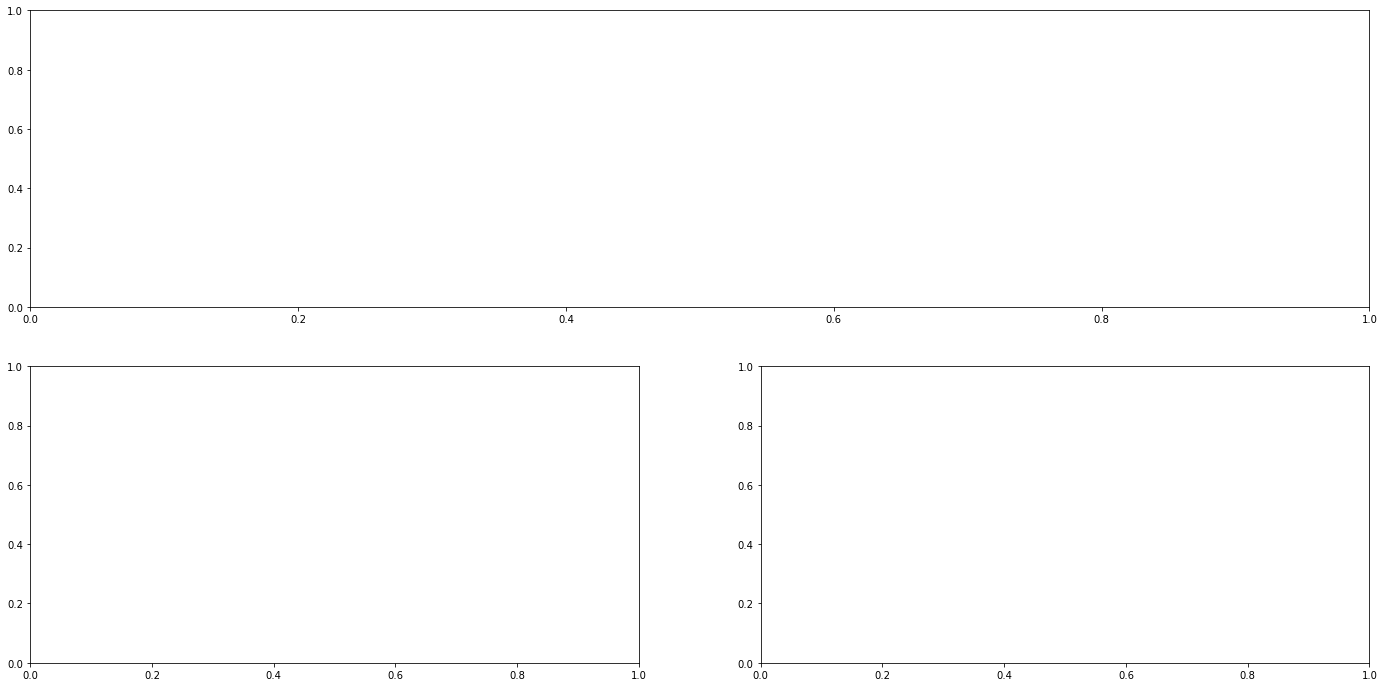

In [13]:
import ipywidgets as widgets
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd 

# convert object columns to date 
df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df['year_week'] = pd.to_datetime(df['date']).dt.strftime('%Y-%U')

date_limit = widgets.SelectionSlider(
    options = df['date'].sort_values().unique().tolist()
    ,value='2014-12-01'
    ,description = 'Max Available Date'
    ,disable = False
    ,continuous_update = False
    ,orientation='horizontal'
    ,style=style
    ,readout = True
)

yr_limit = widgets.SelectionSlider(            
    options = df['yr_renovated'].sort_values().unique().tolist()
    ,value=2000
    ,description='Max Year'
    ,disable=False
    ,continuous_update = False
    ,orientation='horizontal'
    ,style=style
    ,readout = True
)

water_front = widgets.Checkbox(
    value=False
    ,description='Is Water Front?'
    ,disable=False
    ,indent=False
)

def update_map(df, data_limit, yr_limit, is_water_front):
    
    house = df[(df['date'] <= data_limit) & 
              (df['yr_renovated'] >= yr_limit) & 
              (df['waterfront'] == is_water_front)].copy()
    
    fig = plt.figure(figsize=(24,12))
    specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    
    ax1 = fig.add_subplot(specs[0,:])
    ax2 = fig.add_subplot(specs[1,0])
    ax3 = fig.add_subplot(specs[1,1])
    
    by_year = house[['price', 'year']].groupby('year').sum() \
 .reset_index()
    sns.barplot(x='year', y='price', data=by_year, ax=ax1)
    
    by_day = house[['price', 'date']].groupby('date').mean() \
 .reset_index()
    sns.lineplot(x='date', y='price', data=by_day, ax=ax2)
    plt.xticks(rotation=90);
    
    by_week =house[['price', 'year_week']].groupby('year_week') \
    .mean().reset_index()
    sns.barplot(x='year_week', y='price', data=by_week, ax=ax3)
    plt.xticks(rotation=90);
    
widgets.interactive(update_map, 
                    df=fixed(df), 
                    data_limit=date_limit, 
                    yr_limit=yr_limit, 
                    is_water_front=water_front )
    